In [233]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import holidays
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import xgboost as xgb

## Loading and Setting up the data

In [2]:
train = pd.read_excel('C:/Users/Christopher/Downloads/timeseries_forecasting_test.xlsx',sheet_name='train')
test = pd.read_excel('C:/Users/Christopher/Downloads/timeseries_forecasting_test.xlsx',sheet_name='test')

In [3]:
train.set_index('interval_et', inplace=True)
test.set_index('interval_et', inplace=True)

In [6]:
train_hourly = train.resample('H').sum()
test_hourly= test.resample('H').sum()

In [7]:
train_hourly['Weekday'] = train_hourly.index.dayofweek
train_hourly['Hour'] = train_hourly.index.hour
train_hourly['Date'] = train_hourly.index.date
train_hourly['MonthYear'] =train_hourly.index.strftime('%Y-%m')
train_hourly['Month'] =  train_hourly.index.month
train_hourly['Year'] =  train_hourly.index.year

## EDA and Visualization

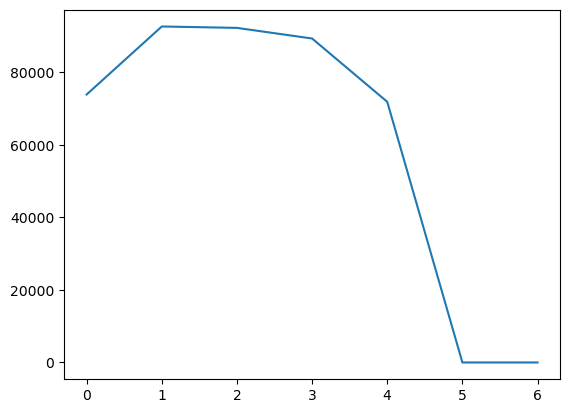

In [280]:
train_weekday = train_hourly.groupby(train_hourly.Weekday, as_index=False)['chats'].sum()
plt.plot(train_weekday.index,train_weekday.chats)
plt.show()

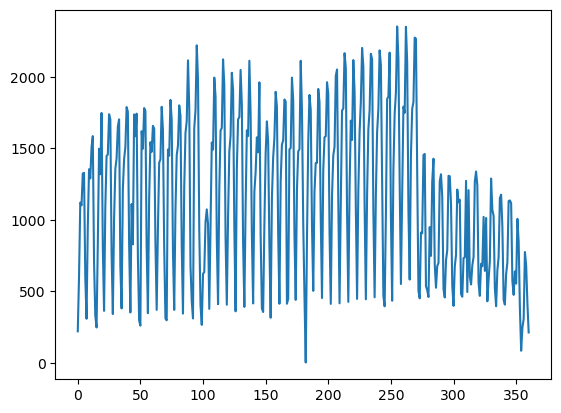

In [278]:
train_day_of_year = train.groupby(train.index.day_of_year, as_index=False)['chats'].sum()
plt.plot(train_day_of_year.index,train_day_of_year.chats)
plt.show()

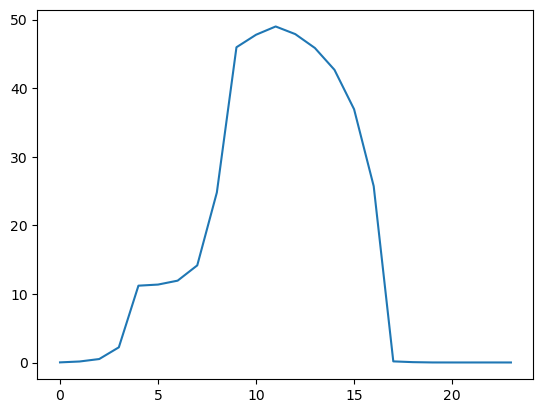

In [281]:
train_hour = train_hourly.groupby(train_hourly.Hour, as_index=False)['chats'].mean()
plt.plot(train_hour.index,train_hour.chats)

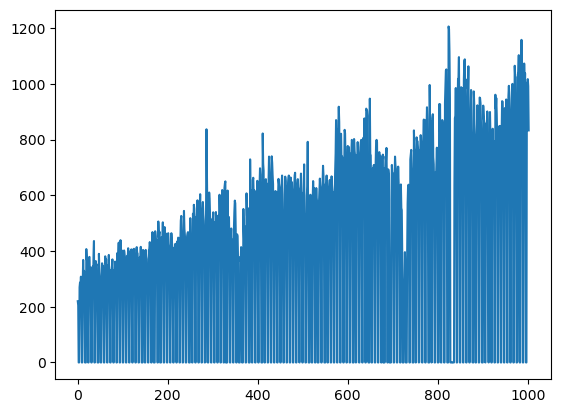

In [282]:
train_date = train_hourly.groupby(train_hourly.Date, as_index=False)['chats'].sum()
plt.plot(train_date.index,train_date.chats)

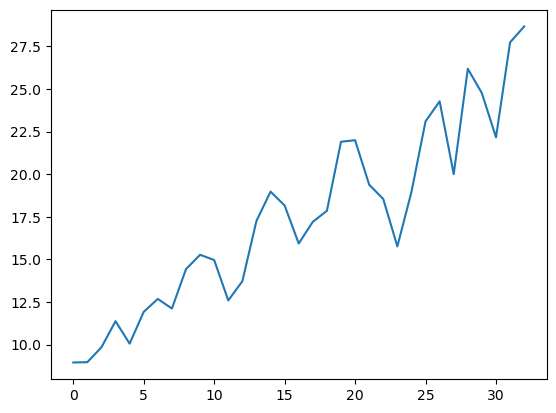

In [283]:
train_monthyear = train_hourly.groupby(train_hourly.MonthYear, as_index=False)['chats'].mean()
plt.plot(train_monthyear.index,train_monthyear.chats)
plt.show()

In [284]:
from matplotlib.ticker import MultipleLocator, FuncFormatter, NullFormatter

In [285]:
train_weekday_hour = train_hourly.groupby([train_hourly.Weekday,train_hourly.Hour])['chats'].mean()

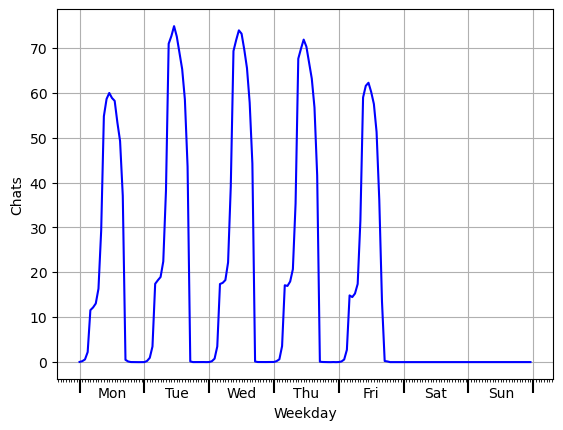

In [287]:
ax = train_weekday_hour.plot(kind='line', color='blue')
ax.set_ylabel("Chats")
ax.set_xlabel("Weekday")
ax.grid()
ax.xaxis.set_major_locator(MultipleLocator(24))
ax.xaxis.set_minor_locator(MultipleLocator(1))
days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
def tick(x,pos):
    if x % 24 == 12:
        return days[int(x)//24]
    else:
        return ""
ax.xaxis.set_major_formatter(NullFormatter())
ax.xaxis.set_minor_formatter(FuncFormatter(tick))
ax.tick_params(which="major", axis="x", length=10, width=1.5)
plt.show()

## Feature Engineering

In [8]:
US_holidays = holidays.country_holidays('US') 

train_hourly['Holiday'] = [0 for x in train_hourly.index]
train_hourly.loc[train_hourly[train_hourly.index.map(lambda d: d in US_holidays)].index,'Holiday'] = 1

In [9]:
train_hourly['Off-peak'] = [1 if train_hourly['Hour'][x] < 4
                            or train_hourly['Hour'][x] > 17
                            else 0
                            for x in train_hourly.index]

train_hourly['Weekend'] = [1 if train_hourly['Weekday'][x] in (5,6)
                           else 0
                           for x in train_hourly.index]

In [10]:
train_hourly['high volume'] = [1 if train_hourly['Holiday'][x] == 0
                               and train_hourly['Off-peak'][x] == 0
                               and train_hourly['Weekend'][x] == 0
                               else 0
                               for x in train_hourly.index]

In [11]:
train_hourly['Obs'] = [x for x in range(1,len(train_hourly)+1)]

train_hourly['Trend'] = [(train_hourly['Obs'][x]/4000)+2 for x in train_hourly.index]

In [13]:
train_hourly['morning'] = [1 if train_hourly['Hour'][x] >= 4
                           and train_hourly['Hour'][x] < 8
                           else 0
                           for x in train_hourly.index]

train_hourly['ramp'] = [1 if train_hourly['Hour'][x] == 8
                        or train_hourly['Hour'][x] == 16
                        else 0
                        for x in train_hourly.index]

train_hourly['peak'] = [1 if train_hourly['Hour'][x] >= 9
                        and train_hourly['Hour'][x] < 16
                        else 0
                        for x in train_hourly.index]

In [14]:
train_hourly['TVmorning'] = [train_hourly['Trend'][x]
                             * train_hourly['high volume'][x]
                             * train_hourly['morning'][x] for x in train_hourly.index]

train_hourly['TVramp'] = [train_hourly['Trend'][x]
                             * train_hourly['high volume'][x]
                             * train_hourly['ramp'][x] for x in train_hourly.index]

train_hourly['TVpeak'] = [train_hourly['Trend'][x]
                             * train_hourly['high volume'][x]
                             * train_hourly['peak'][x] for x in train_hourly.index]

## Duplicate Features in the hourly Test set

In [213]:
test_hourly['Weekday'] = test_hourly.index.dayofweek
test_hourly['Hour'] = test_hourly.index.hour
test_hourly['Date'] = test_hourly.index.date
test_hourly['Month'] =  test_hourly.index.month
test_hourly['Year'] =  test_hourly.index.year

test_hourly['Holiday'] = [0 for x in test_hourly.index]
test_hourly.loc[test_hourly[test_hourly.index.map(lambda d: d in US_holidays)].index,'Holiday'] = 1


In [ ]:
test_hourly['Off-peak'] = [1 if test_hourly['Hour'][x] < 4
                           or test_hourly['Hour'][x] > 17
                           else 0
                           for x in test_hourly.index]

test_hourly['Weekend'] = [1 if test_hourly['Weekday'][x] in (5,6)
                          else 0
                          for x in test_hourly.index]

test_hourly['high volume'] = [1 if test_hourly['Holiday'][x] == 0
                              and test_hourly['Off-peak'][x] == 0
                              and test_hourly['Weekend'][x] == 0
                              else 0
                              for x in test_hourly.index]


In [ ]:
test_hourly['Obs'] = [x for x in range(24057,len(test_hourly)+24057)]
test_hourly['Trend'] = [(test_hourly['Obs'][x]/4000)+2 for x in test_hourly.index]

In [226]:
test_hourly['morning'] = [1 if test_hourly['Hour'][x] >= 4
                          and test_hourly['Hour'][x] < 8
                          else 0
                          for x in test_hourly.index]

test_hourly['ramp'] = [1 if test_hourly['Hour'][x] == 8
                       or test_hourly['Hour'][x] == 16
                       else 0
                       for x in test_hourly.index]

test_hourly['peak'] = [1 if test_hourly['Hour'][x] >= 9
                       and test_hourly['Hour'][x] < 16
                       else 0
                       for x in test_hourly.index]

In [215]:
test_hourly['TVmorning'] = [test_hourly['Trend'][x]
                             *test_hourly['high volume'][x]
                             *test_hourly['morning'][x] for x in test_hourly.index]

In [216]:
test_hourly['TVramp'] = [test_hourly['Trend'][x]
                             *test_hourly['high volume'][x]
                             *test_hourly['ramp'][x] for x in test_hourly.index]

In [217]:
test_hourly['TVpeak'] = [test_hourly['Trend'][x]
                             *test_hourly['high volume'][x]
                             *test_hourly['peak'][x] for x in test_hourly.index]

## Feature Heatmap

C:\Users\Christopher\AppData\Local\Temp\ipykernel_35500\3090389188.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_hourly.corr(), annot = True,fmt=".2f")


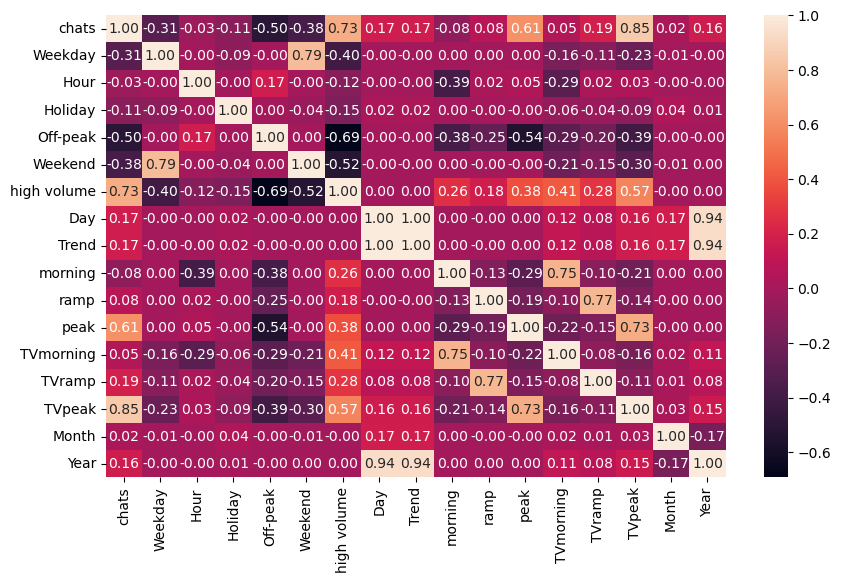

In [77]:
plt.figure(figsize=(10,6))
sns.heatmap(train_hourly.corr(), annot = True, fmt=".2f")
plt.show()

## OLS Model

In [293]:
mod = sm.OLS(train_hourly['chats'],train_hourly[['TVmorning','TVramp','TVpeak']])
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                  chats   R-squared (uncentered):                   0.894
Model:                            OLS   Adj. R-squared (uncentered):              0.894
Method:                 Least Squares   F-statistic:                          6.769e+04
Date:                Thu, 14 Dec 2023   Prob (F-statistic):                        0.00
Time:                        06:01:32   Log-Likelihood:                         -91828.
No. Observations:               24057   AIC:                                  1.837e+05
Df Residuals:                   24054   BIC:                                  1.837e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [242]:
OLS_pred = res.predict(test_hourly[['TVmorning','TVramp','TVpeak']])
test_hourly['OLS_pred'] = OLS_pred

In [243]:
test_hourly['residual'] = test_hourly['chats'] - test_hourly['OLS_pred']
print('MAE: ',sum(abs(test_hourly['residual']))/len(test_hourly))

MAE:  7.5685454669790255


In [291]:
print('Total chats recieved: ', test_hourly['chats'].sum())
print('Total predicted chats: ',test_hourly['OLS_pred'].sum())
print('Prediction Difference: ',100*(test_hourly['chats'].sum()-test_hourly['OLS_pred'].sum())
      /test_hourly['chats'].sum(),'%')

Total chats recieved:  61953
Total predicted chats:  59655.41531044559
Prediction Difference:  3.7085931101874148 %


In [273]:
print('Coverage: ', round((1-len(test_hourly[test_hourly['residual'] < 0])/len(test_hourly))*100,2),'%')

Coverage:  85.55 %


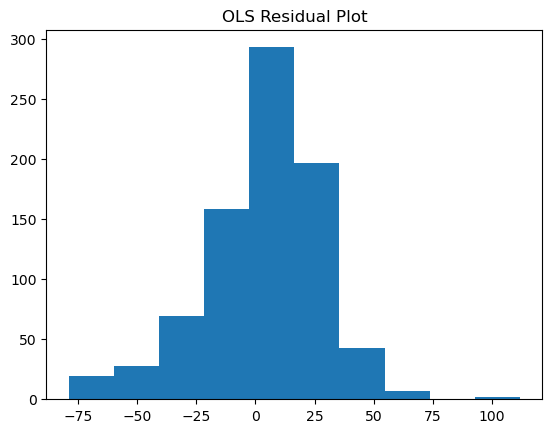

In [200]:
plt.hist(test_hourly[test_hourly['chats'] !=0]['residual'])
plt.title('OLS Residual Plot')
plt.show()

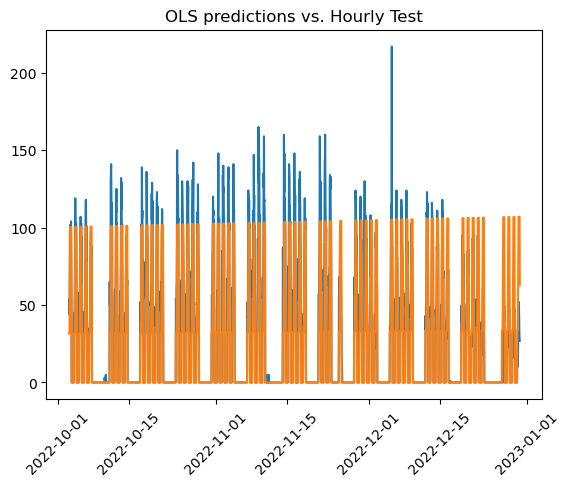

In [199]:
plt.plot(test_hourly.index, test_hourly.chats)
plt.plot(test_hourly.index, test_hourly.OLS_pred)
plt.title('OLS predictions vs. Hourly Test')
plt.xticks(rotation=45)
plt.show()

## Daily Dataset Creation

In [92]:
train_daily = pd.read_excel('C:/Users/Christopher/Downloads/timeseries_forecasting_test.xlsx',sheet_name='train')
train_daily.set_index('interval_et', inplace=True)
train_daily = train_daily.resample('D').sum()

In [156]:
train_daily['Holiday'] = [0 for x in train_daily.index]
train_daily.loc[train_daily[train_daily.index.map(lambda d: d in US_holidays)].index,'Holiday'] = 1

train_daily['Weekday'] = train_daily.index.dayofweek
train_daily['Weekend'] = [1 if train_daily['Weekday'][x] in (5,6) else 0 for x in train_daily.index]

train_daily['DayOff'] = [1 if train_daily['Weekend'][x] == 1 
                         or train_daily['Holiday'][x] == 1
                         else 0
                         for x in train_daily.index]

In [144]:
test_daily = pd.read_excel('C:/Users/Christopher/Downloads/timeseries_forecasting_test.xlsx',sheet_name='test')
test_daily.set_index('interval_et', inplace=True)
test_daily = test_daily.resample('D').sum()

In [159]:
test_daily['Holiday'] = [0 for x in test_daily.index]
test_daily.loc[test_daily[test_daily.index.map(lambda d: d in US_holidays)].index,'Holiday'] = 1

test_daily['Weekday'] = test_daily.index.dayofweek
test_daily['Weekend'] = [1 if test_daily['Weekday'][x] in (5,6) else 0 for x in test_daily.index]

test_daily['DayOff'] = [1 if test_daily['Weekend'][x] == 1 
                        or test_daily['Holiday'][x] == 1
                        else 0
                        for x in test_daily.index]

## Daily SARIMAX Model

In [124]:
import pmdarima
from pmdarima import ARIMA

In [164]:
auto_model = pmdarima.arima.auto_arima(train_daily['chats'], x=train_daily['DayOff'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1003
Model:               SARIMAX(5, 1, 2)   Log Likelihood               -6573.823
Date:                Thu, 14 Dec 2023   AIC                          13163.646
Time:                        06:01:43   BIC                          13202.924
Sample:                    01-02-2020   HQIC                         13178.573
                         - 09-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2781      0.035      7.944      0.000       0.209       0.347
ar.L2         -0.7959      0.032    -25.027      0.000      -0.858      -0.734
ar.L3         -0.1810      0.034     -5.249      0.000      -0.249      -0.113
ar.L4         -0.4158      0.021    -19.425      0.000      -0.458      -0.374
ar.L5         -0.4652      0.029    -16.237      0.000      -0.521      -0.409
ma.L1         -1.0071      0.018    -54.596      0.000      -1.043      -0.971
ma.L2          0.7486      0.019     39.778      0.000       0.712       0.786
sigma2      2.956e+04   1004.352     29.436      0.000    2.76e+04    3.15e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):               773.43
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               4.50   Skew:                            -0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

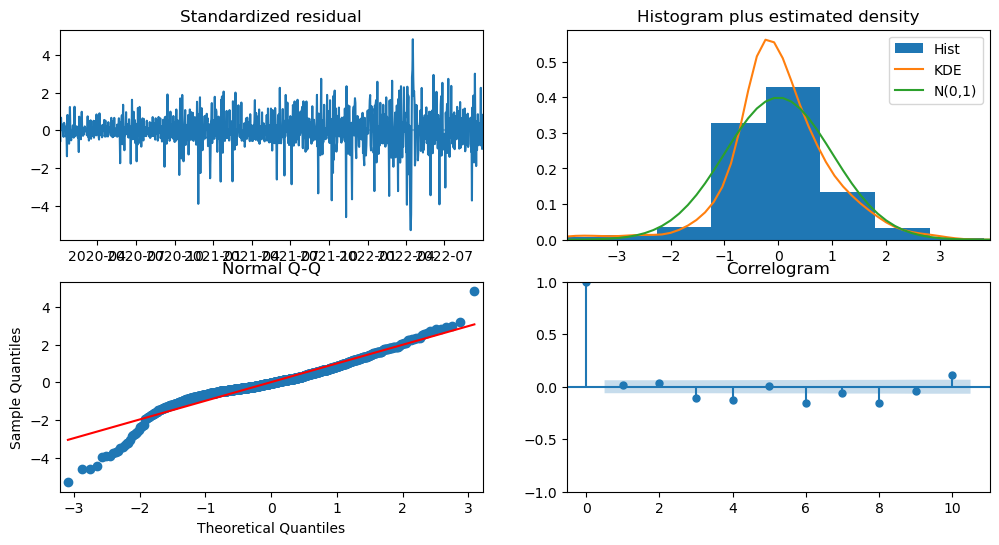

In [294]:
display(auto_model.summary())
auto_model.plot_diagnostics(figsize=(12,6));

In [166]:
auto = auto_model.fit(train_daily['chats'], x=train_daily['DayOff'])

In [173]:
forecast = auto.predict(n_periods = 91, x=test_daily['DayOff'])

In [175]:
test_daily['sarima_pred'] = forecast.values[2:]

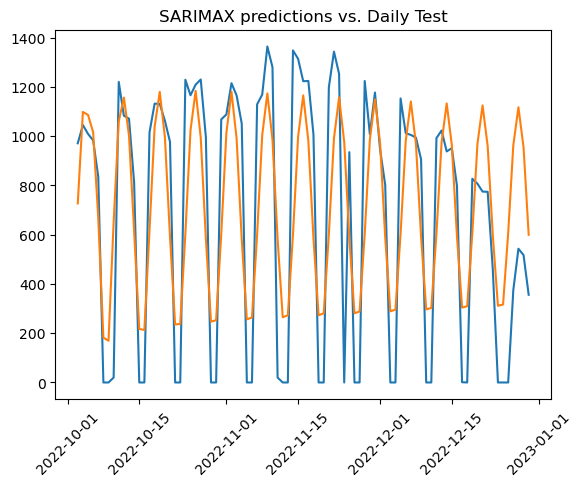

In [195]:
plt.plot(test_daily.index, test_daily.chats)
plt.plot(test_daily.index, test_daily.sarima_pred)
plt.title('SARIMAX predictions vs. Daily Test')
plt.xticks(rotation=45)
plt.show()

In [188]:
test_daily['residual'] = test_daily['chats'] - test_daily['sarima_pred']
print('MAE: ', sum(abs(test_daily['residual']))/len(test_daily))

MAE:  268.9752925284216


In [276]:
print('Total chats recieved: ', test_daily['chats'].sum())
print('Total predicted chats: ', test_daily['sarima_pred'].sum())
print('Prediction Difference: ', 100/test_daily['chats'].sum(),'%')

Total chats recieved:  61953
Total predicted chats:  62953.33272797216
Prediction Difference:  0.0016141268380869369 %


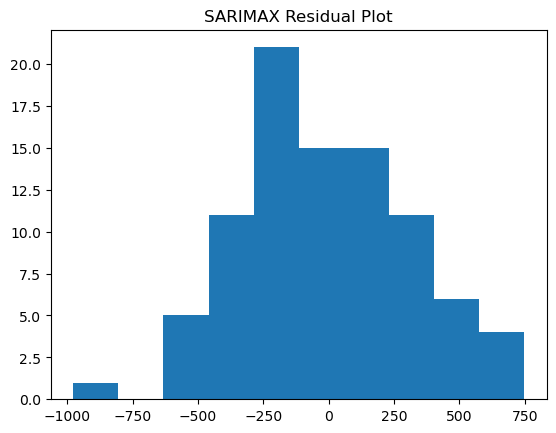

In [227]:
plt.hist(test_daily['residual'])
plt.title('SARIMAX Residual Plot')
plt.show()

In [228]:
test_daily['sarima_coerce'] = [test_daily['sarima_pred'][x]
                               if test_daily['DayOff'][x] ==0 else 0 for x in test_daily.index]

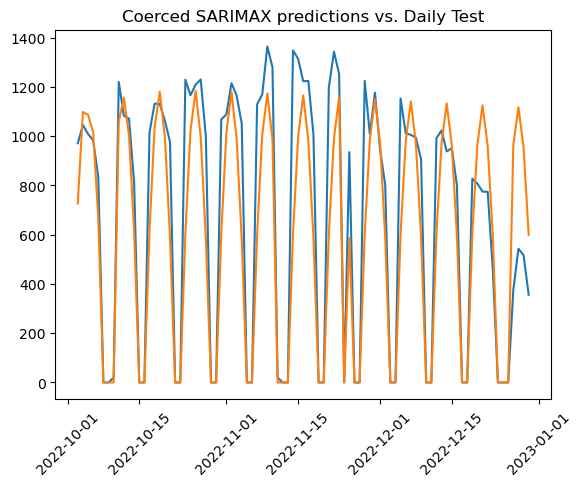

In [194]:
plt.plot(test_daily.index, test_daily.chats)
plt.plot(test_daily.index, test_daily.sarima_coerce)
plt.title('Coerced SARIMAX predictions vs. Daily Test')
plt.xticks(rotation=45)
plt.show()

In [189]:
test_daily['residual_coerce'] = test_daily['chats'] - test_daily['sarima_coerce']
print('MAE: ', sum(abs(test_daily['residual_coerce']))/len(test_daily))

MAE:  166.79099231318085


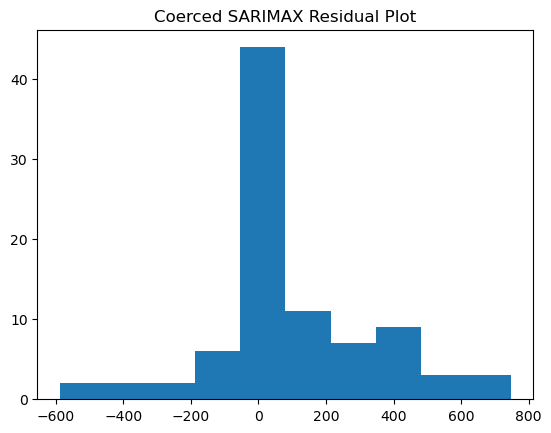

In [234]:
plt.hist(test_daily['residual_coerce'])
plt.title('Coerced SARIMAX Residual Plot')
plt.show()

## Daily SARIMAX Decomposed into Hourly Prediction

In [93]:
train_hourly['Date'] = pd.to_datetime(train_hourly['Date'])
train_hourly = train_hourly.merge(train_daily['chats'],
                                  left_on='Date',
                                  right_on=train_daily.index,
                                  suffixes=[None,"_daily"])

In [97]:
train_hourly['hour_prop'] = [train_hourly['chats'][x]
                             / train_hourly['chats_daily'][x] if train_hourly['chats_daily'][x] != 0 else 1 
                             for x in train_hourly.index]

In [105]:
hour_means=[]
for x in range (0,24):
    hour_means.append((train_hourly[(train_hourly['Hour'] == x) & (train_hourly['hour_prop'] !=1)]['hour_prop'].mean()))
print(sum(hour_means))

In [108]:
adjusted_hour_means=[]
for x in range (0,24):
    adjusted_hour_means.append(hour_means[x]/sum(hour_means))
print(sum(adjusted_hour_means))

In [205]:
ahm = pd.DataFrame(adjusted_hour_means, columns=['hour_distribution'])

In [219]:
test_hourly=test_hourly.merge(ahm, how='left', left_on='Hour', right_on=ahm.index)

In [222]:
test_hourly['Date'] = pd.to_datetime(test_hourly['Date'])
test_hourly=test_hourly.merge(test_daily['sarima_coerce'], how='left', left_on='Date', right_on=test_daily.index)

In [223]:
test_hourly['distributed_sarima'] = test_hourly['hour_distribution']*test_hourly['sarima_coerce']

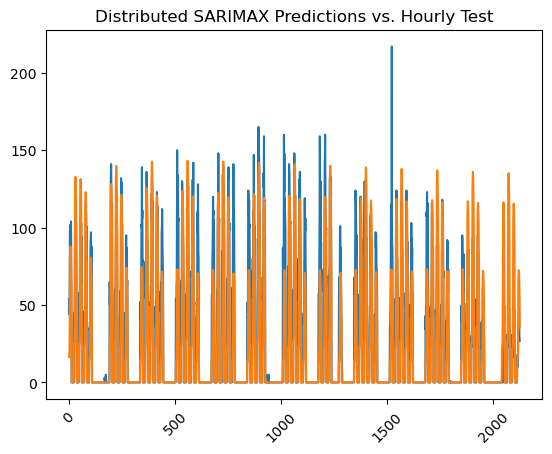

In [224]:
plt.plot(test_hourly.index, test_hourly.chats)
plt.plot(test_hourly.index, test_hourly.distributed_sarima)
plt.title('Distributed SARIMAX Predictions vs. Hourly Test')
plt.xticks(rotation=45)
plt.show()

In [225]:
test_hourly['residual_sarima'] = test_hourly['chats'] - test_hourly['distributed_sarima']
print('MAE: ',sum(abs(test_hourly['residual_sarima']))/len(test_hourly))

MAE:  9.770988784383002


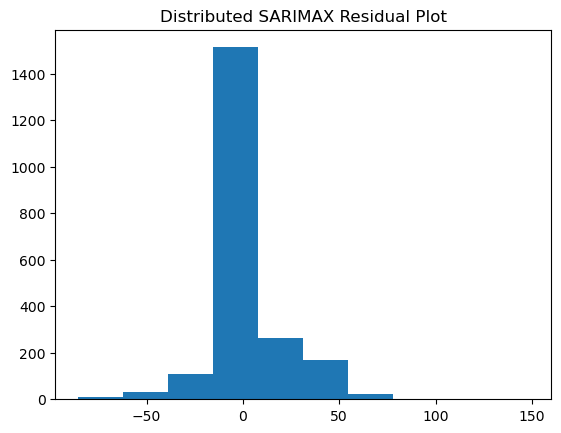

In [236]:
plt.hist(test_hourly['residual_sarima'])
plt.title('Distributed SARIMAX Residual Plot')
plt.show()

## XGBoost Regressor

In [252]:
X_train,y_train = train_hourly[['Weekday', 'Hour', 'high volume', 'Day', 'Trend',
       'morning', 'ramp', 'peak', 'TVmorning', 'TVramp', 'TVpeak', 'Month','Year']], train_hourly['chats']

X_test,y_test = test_hourly[['Weekday', 'Hour', 'high volume', 'Day', 'Trend',
       'morning', 'ramp', 'peak', 'TVmorning', 'TVramp', 'TVpeak', 'Month','Year']], test_hourly['chats']

In [253]:
# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train)
dtest_reg = xgb.DMatrix(X_test, y_test)

In [263]:
params = {"objective": "reg:squarederror","device":"cuda", "tree_method": "hist"}

evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=250,
   evals=evals,
   verbose_eval=20,
   early_stopping_rounds=100
)

[0]	train-rmse:21.09380	validation-rmse:33.01148
[20]	train-rmse:5.52365	validation-rmse:14.72535
[40]	train-rmse:5.03116	validation-rmse:15.40256
[60]	train-rmse:4.71775	validation-rmse:15.65841
[80]	train-rmse:4.49124	validation-rmse:15.85750
[100]	train-rmse:4.33723	validation-rmse:15.94926
[115]	train-rmse:4.22708	validation-rmse:16.13223


In [264]:
boost_preds = model.predict(dtest_reg)
test_hourly['boost_preds'] = boost_preds

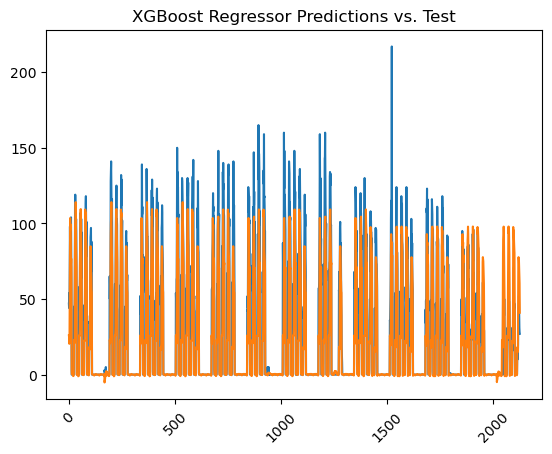

In [265]:
plt.plot(test_hourly.index, test_hourly.chats)
plt.plot(test_hourly.index, test_hourly.boost_preds)
plt.title('XGBoost Regressor Predictions vs. Test')
plt.xticks(rotation=45)
plt.show()

In [266]:
test_hourly['boost_residual'] = test_hourly['chats'] - test_hourly['boost_preds']

print('MAE: ', sum(abs(test_hourly['boost_residual']))/len(test_hourly))

MAE:  8.417984793719123


In [90]:
print(test_hourly['chats'].sum())
print(test_hourly['boost_preds'].sum())

61953
51114.996


In [290]:
print('Total chats recieved: ', test_hourly['chats'].sum())
print('Total predicted chats: ', test_hourly['boost_preds'].sum())
print('Prediction Difference: ', 100*(test_hourly['chats'].sum()-test_hourly['boost_preds'].sum())
      /test_hourly['chats'].sum(),'%')

Total chats recieved:  61953
Total predicted chats:  50226.17
Prediction Difference:  18.928588002195212 %


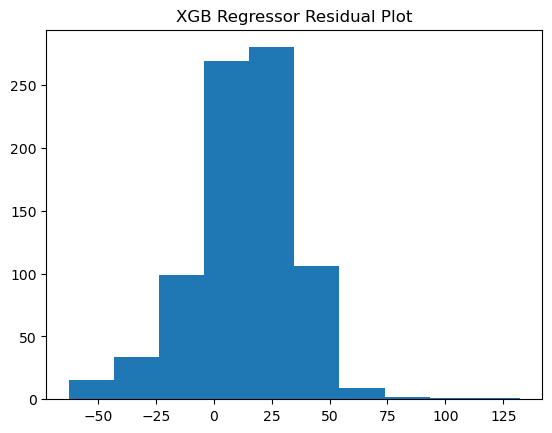

In [191]:
plt.hist(test_hourly[test_hourly['chats'] !=0]['boost_residual'])
plt.title('XGB Regressor Residual Plot')
plt.show()